### Importing necessary libraries

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from urllib.parse import urlparse
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))
     
from src.loader import NewsDataLoader

### Loading Data

In [2]:
loader=NewsDataLoader()
ratingData = loader.load_data('../data/raw/data.csv/rating.csv')
trafficData = loader.load_data('../data/raw/traffic_data/traffic.csv')
locationData = loader.load_data('../data/raw/Domains_location.csv')

### Data Overview

#### 1. Rating Dataset

In [3]:
ratingData.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral


In [4]:
ratingData.shape

(58356, 13)

#### 2. Traffic Dataset

In [5]:
trafficData.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


###

In [6]:
trafficData.shape

(1000000, 12)

#### 3. Domains location Dataset

In [7]:
locationData.head()

,SourceCommonName,location,Country
0,00221.info,SG,Senegal
1,01net.com,FR,France
2,01net.it,IT,Italy
3,0223.com.ar,AR,Argentina
4,022china.com,CH,China


In [8]:
locationData.shape

(37802, 3)

### Extract the Domain from the url in the rating dataset

In [9]:
ratingData['domain'] = ratingData['url'].apply(lambda x: urlparse(x).netloc)

In [10]:
ratingData.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment,domain
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral,www.forbes.com
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive,www.channelnewsasia.com
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative,time.com
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral,phys.org
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral,www.digitaltrends.com


In [11]:
ratingdata_domains = ratingData['domain'].unique()
print(ratingdata_domains) 

['www.forbes.com' 'www.channelnewsasia.com' 'time.com' 'phys.org'
 'www.digitaltrends.com' 'www.aljazeera.com' 'www.bbc.co.uk'
 'deadline.com' 'www.euronews.com' 'www.rt.com' 'punchng.com'
 'www.ibtimes.com' 'indianexpress.com' 'www.etfdailynews.com'
 'abcnews.go.com' 'www.globalsecurity.org' 'www.marketscreener.com'
 'timesofindia.indiatimes.com' 'www.globenewswire.com'
 'economictimes.indiatimes.com' 'cnalifestyle.channelnewsasia.com'
 'www.cnn.com' 'www.businessinsider.com' 'gizmodo.com' 'www.wired.com'
 'www.theverge.com' 'www.npr.org' 'boingboing.net'
 'www.androidcentral.com' 'readwrite.com' 'www.bbc.com'
 'cnaluxury.channelnewsasia.com' 'allafrica.com']


### merge  the traffic dataset and the location dataset

In [12]:

traffic_location_df = pd.merge(trafficData, locationData, left_on='Domain', right_on='SourceCommonName', how='inner')
traffic_location_df.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,SourceCommonName,location,Country
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402,google.com,US,United States
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135,facebook.com,VM,Vietnam
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940,youtube.com,US,United States
3,7,7,apple.com,com,263655,804726,apple.com,com,7,7,263416,801213,apple.com,US,United States
4,8,8,microsoft.com,com,260546,739096,microsoft.com,com,8,8,260326,736093,microsoft.com,US,United States


### merge the traffic_location merged dataset with the rating dataset

In [13]:
merged_df=pd.merge(ratingData,traffic_location_df,left_on='domain',right_on='Domain',how='inner')
merged_df.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,...,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,SourceCommonName,location,Country
0,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",...,133712,time.com,com,135,91,57983,133000,time.com,US,United States
1,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,...,49640,phys.org,org,622,81,25158,49348,phys.org,US,United States
2,81719,NaN,Phys.Org,Carlyn Chatfield,researcher scans tropical forest with mixed-re...,Rice University scientists used a commercially...,https://phys.org/news/2023-10-scans-tropical-f...,https://scx2.b-cdn.net/gfx/news/2023/rice-rese...,2023-10-19 20:02:03.000000,Rice University scientists used a commercially...,...,49640,phys.org,org,622,81,25158,49348,phys.org,US,United States
3,81723,NaN,Deadline,Patrick Hipes,"‘taylor swift: the eras tour’ movie: tickets, ...",Taylor Swift has the highest-grossing concert ...,https://deadline.com/feature/taylor-swift-eras...,https://deadline.com/wp-content/uploads/2023/1...,2023-10-11 14:30:00.000000,Taylor Swift has the highest-grossing concert ...,...,43299,deadline.com,com,962,549,19347,43044,deadline.com,US,United States
4,81731,NaN,Phys.Org,"Louw Claassens, David Harasti, Graham Short",tiny and mysterious: research sheds light on s...,Seahorses are considered fabled creatures by m...,https://phys.org/news/2023-10-tiny-mysterious-...,https://scx2.b-cdn.net/gfx/news/hires/2021/sea...,2023-10-25 16:52:04.000000,Seahorses are considered fabled creatures by m...,...,49640,phys.org,org,622,81,25158,49348,phys.org,US,United States


## Exploratory Data Analysis (EDA)

### 1. Websites that have the largest count of news articles

In [14]:
# Count the number of articles per website
website_counts = ratingData['domain'].value_counts().reset_index()
website_counts.columns = ['domain', 'count']
print(website_counts[:10])


                         domain  count
0          www.etfdailynews.com  16746
1         www.globenewswire.com   5423
2  economictimes.indiatimes.com   5310
3        www.globalsecurity.org   3119
4                www.forbes.com   2784
5   timesofindia.indiatimes.com   2194
6                abcnews.go.com   2058
7       www.businessinsider.com   2034
8                 www.bbc.co.uk   2032
9                   punchng.com   1800


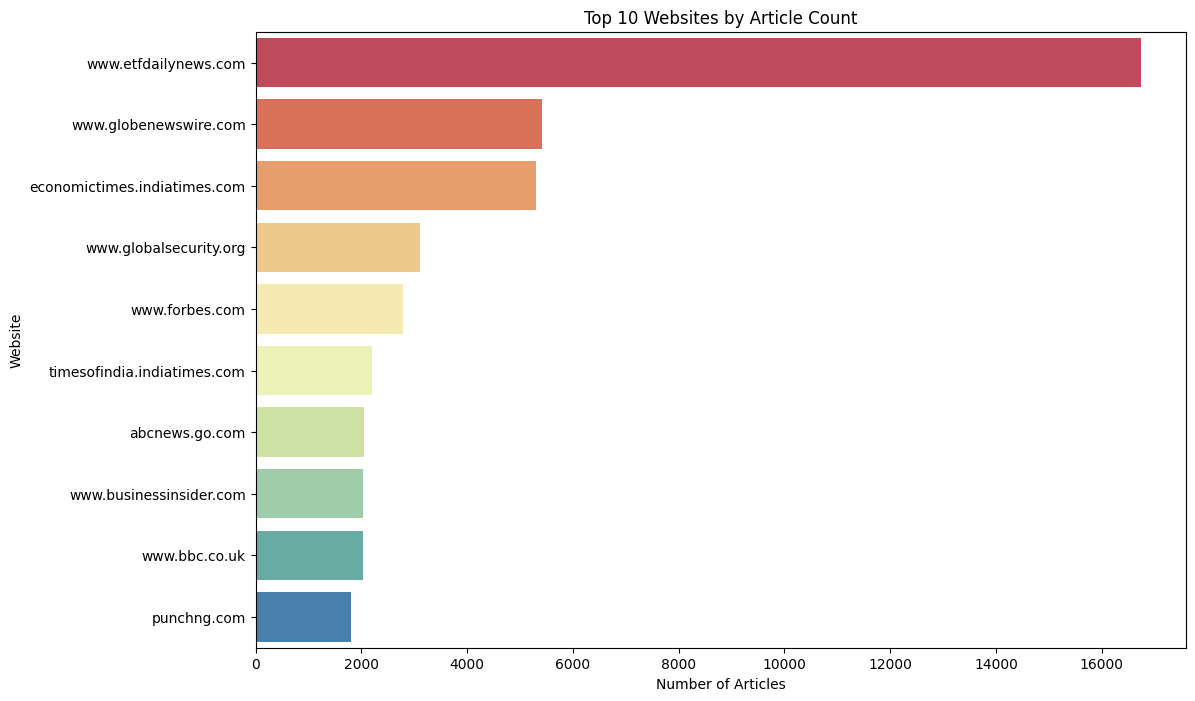

In [15]:
# Plot the top 10 websites by article count
plt.figure(figsize=(12, 8))
sns.barplot(data=website_counts.head(10), x='count', y='domain', hue='domain', palette='Spectral', legend=False)
plt.title('Top 10 Websites by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Website')
plt.show()

### 2. Websites with the highest numbers of visitors traffic 


In [16]:
top_traffic_websites = trafficData.sort_values('GlobalRank').head(10)
print(top_traffic_websites['Domain'])

0              google.com
1            facebook.com
2             youtube.com
3             twitter.com
4           instagram.com
5            linkedin.com
6               apple.com
7           microsoft.com
8    googletagmanager.com
9           wikipedia.org
Name: Domain, dtype: object


### 3. Countries with the highest number of news media 

In [17]:
# Count the number of Country per domain
country_counts = traffic_location_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'domain']
top_10_Countries=country_counts[:10]
print(top_10_Countries)


          Country  domain
0   United States   10343
1  United Kingdom    1505
2           Italy     868
3         Germany     712
4          France     691
5          Russia     668
6          Canada     540
7           China     483
8       Australia     481
9           India     411


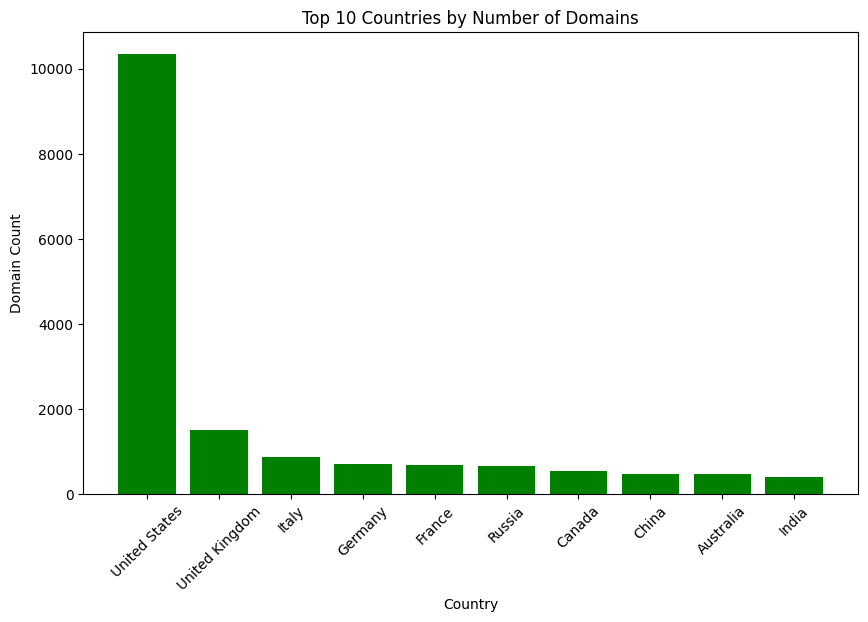

In [18]:
# Plotting the top 10 countries by domain count
plt.figure(figsize=(10, 6))
plt.bar(top_10_Countries['Country'], top_10_Countries['domain'], color='green')
plt.xlabel('Country')
plt.ylabel('Domain Count')
plt.title('Top 10 Countries by Number of Domains')
plt.xticks(rotation=45)
plt.show()